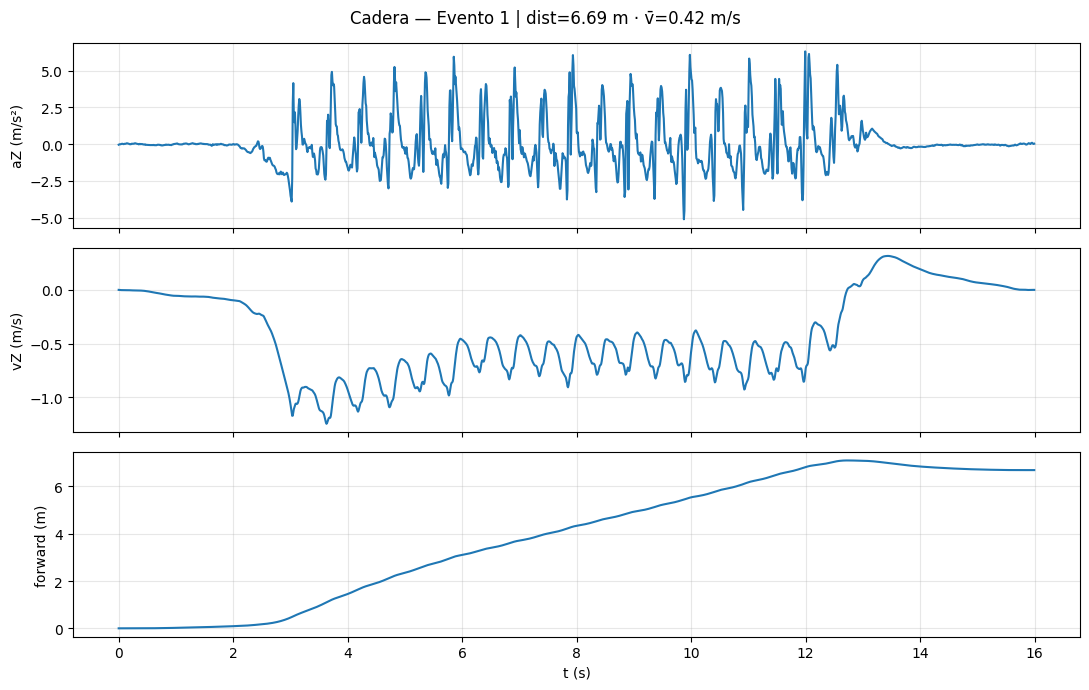

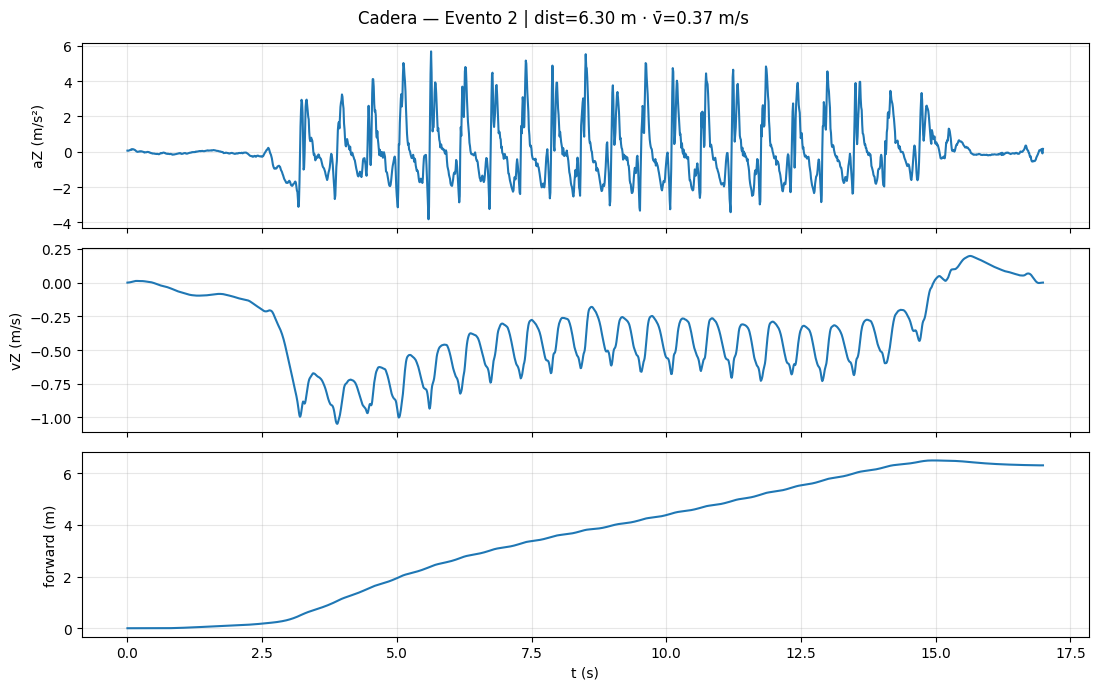

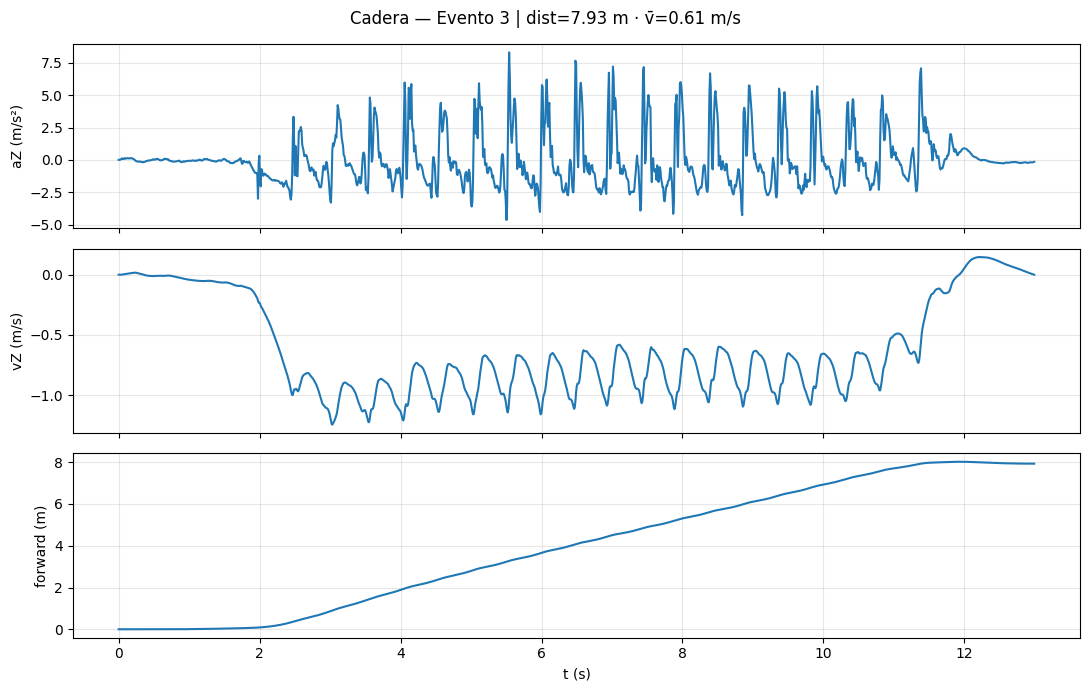

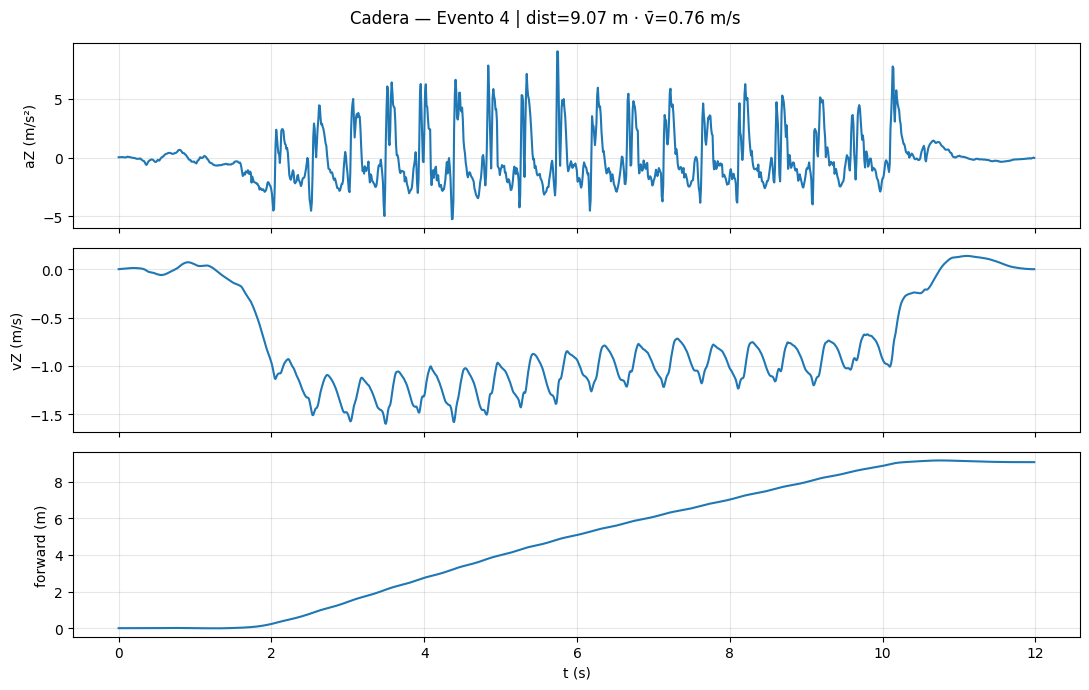

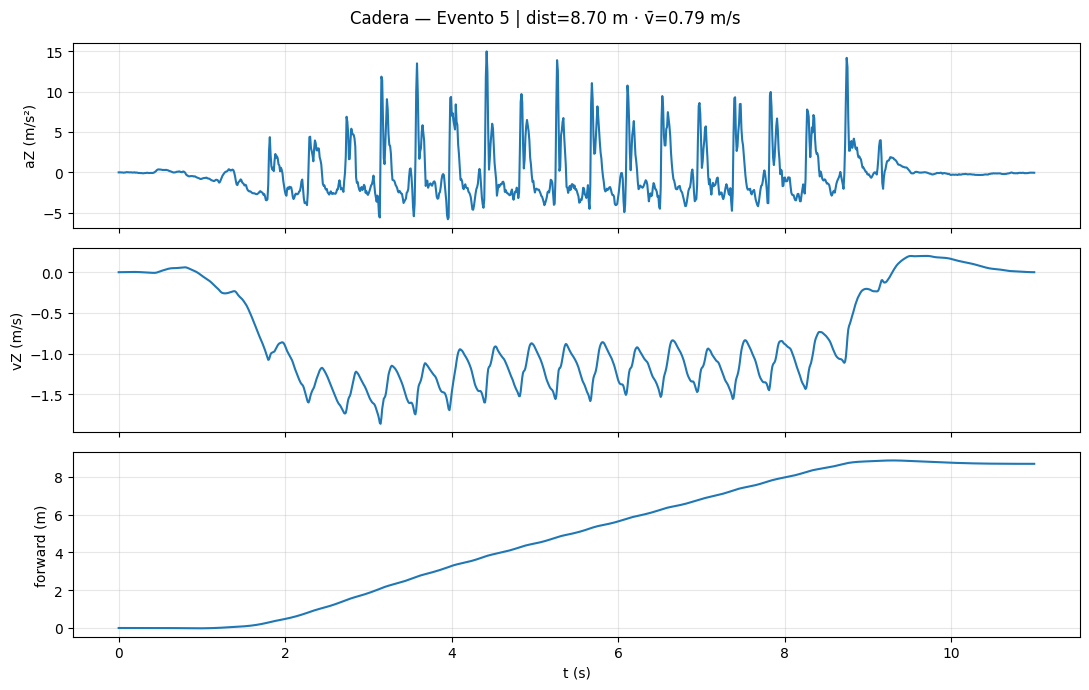

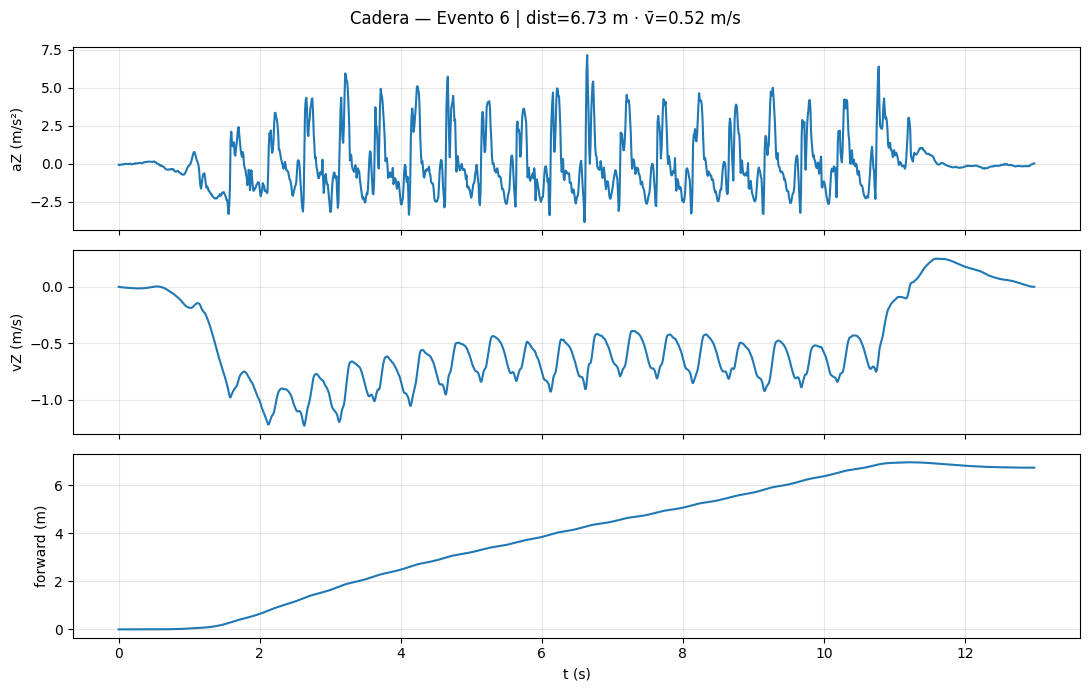

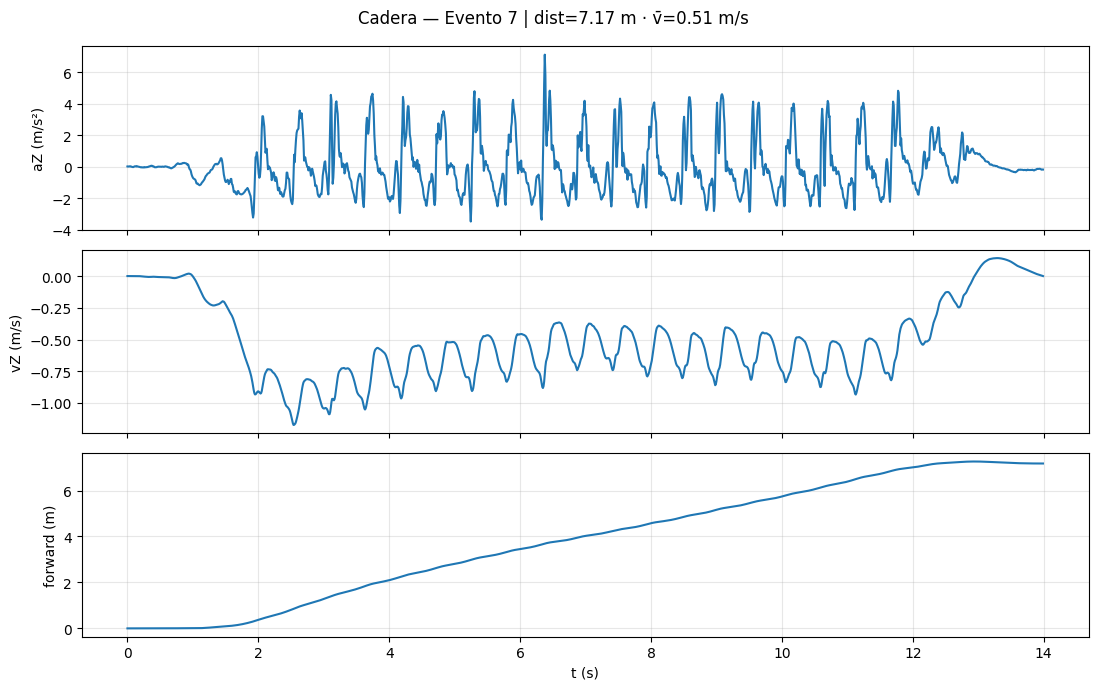


Resumen integración CADERA (RK4) por muestra:
 muestra  grabacion  evento_original    t0_s    t1_s  duracion_s  dist_forward_m  vel_media_mps
       1          1                2  78.000  94.000      16.000           6.687          0.418
       2          1                5 184.000 201.000      17.000           6.301          0.371
       3          2                1  32.000  45.000      13.000           7.928          0.610
       4          2                2  54.000  66.000      12.000           9.065          0.755
       5          2                3  74.000  85.000      11.000           8.695          0.790
       6          2                4  93.000 106.000      13.000           6.729          0.518
       7          2                5 114.000 128.000      14.000           7.175          0.512

Guardado: integracion_cadera_RK4_resumen.csv y carpeta series_cadera_rk4/


In [ ]:
# %% Integración CADERA con RK4 (sin restar media) y v(0)=v(T)=0
# Figuras etiquetadas como: "Cadera — Evento {1..7}"
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Intervalos ----------
EVENTS = {
    1: [(51.0, 69.0), (78.0, 94.0), (116.0, 137.0), (147.0, 171.0), (184.0, 201.0)],
    2: [(32.0, 45.0), (54.0, 66.0), (74.0, 85.0), (93.0, 106.0), (114.0, 128.0)]
}

# Eventos a EXCLUIR (G1: 1,3,4)
EXCLUDE_EVENTS = {1: [1, 3, 4], 2: []}

FORWARD_SIGN = -1.0   # Z+ contrario al avance
SAVE_SERIES  = True   # guardar CSV por muestra (a, v, p, forward)

plt.rcParams.update({"axes.grid": True, "grid.alpha": 0.3})

# ---------- Utilidades de E/S ----------
def load_fixed_format(csv_path: str):
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    req = {"seconds_elapsed", "z", "y", "x"}
    if not req.issubset(df.columns):
        raise ValueError(f"{csv_path}: faltan columnas {req - set(df.columns)}")
    t  = pd.to_numeric(df["seconds_elapsed"], errors="coerce").to_numpy()
    ax = pd.to_numeric(df["x"], errors="coerce").to_numpy()
    ay = pd.to_numeric(df["y"], errors="coerce").to_numpy()
    az = pd.to_numeric(df["z"], errors="coerce").to_numpy()
    m = np.isfinite(t) & np.isfinite(ax) & np.isfinite(ay) & np.isfinite(az)
    return t[m], ax[m], ay[m], az[m]

def find_file(stem: str, idx: int):
    pattern = fr"(?i){stem}{idx}\.csv$"
    cands = [f for f in glob.glob(f"*{stem}*.csv") if re.search(pattern, os.path.basename(f))]
    return sorted(cands)[0] if cands else None

def crop(t, X, t0, t1):
    m = (t >= t0) & (t <= t1)
    return t[m], X[m]

def integrate_trapz_time(t, x):
    if len(t) < 2: return np.zeros_like(x)
    dt = np.diff(t)
    inc = (x[1:] + x[:-1]) * dt / 2.0
    return np.r_[0.0, np.cumsum(inc)]

# ---------- RK4 para dv/dt=a(t), dp/dt=v ----------
def rk4_integrate_avp(t, a_xyz):
    n = len(t)
    v = np.zeros((n, 3), dtype=float)
    p = np.zeros((n, 3), dtype=float)

    def a_at(ts):
        ax = np.interp(ts, t, a_xyz[:, 0])
        ay = np.interp(ts, t, a_xyz[:, 1])
        az = np.interp(ts, t, a_xyz[:, 2])
        return np.column_stack([ax, ay, az])

    for k in range(n - 1):
        tk  = t[k]; dt = t[k+1] - tk; t12 = tk + dt/2.0; t1 = tk + dt
        a_k  = a_at(tk)
        a_12 = a_at(t12)
        a_1  = a_at(t1)

        k1_v = a_k
        k1_p = v[k:k+1]
        k2_v = a_12
        k2_p = v[k:k+1] + (dt/2.0) * k1_v
        k3_v = a_12
        k3_p = v[k:k+1] + (dt/2.0) * k2_v
        k4_v = a_1
        k4_p = v[k:k+1] + dt * k3_v

        v[k+1] = v[k] + (dt/6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
        p[k+1] = p[k] + (dt/6.0) * (k1_p + 2*k2_p + 2*k3_p + k4_p)

    return v, p

# ---------- Única condición: v(0)=v(T)=0 ----------
def enforce_zero_velocity_ends(t, v):
    if len(t) < 2: return v.copy()
    T = t[-1] - t[0]
    if T <= 0: return v.copy()
    ramp = ((t - t[0]) / T)[:, None] * v[-1]
    return v - ramp

# ---------- Proceso de una muestra (para etiquetar 1..7) ----------
def process_sample(global_idx, t_ev, acc_ev, t0, t1):
    v_rk4, _ = rk4_integrate_avp(t_ev, acc_ev)
    v_corr = enforce_zero_velocity_ends(t_ev, v_rk4)
    p_corr = np.column_stack([integrate_trapz_time(t_ev, v_corr[:, i]) for i in range(3)])

    tt = t_ev - t_ev[0]
    forward = FORWARD_SIGN * (p_corr[:, 2] - p_corr[0, 2])
    dist = float(forward[-1])
    dur  = float(t1 - t0)
    vbar = dist / dur if dur > 0 else np.nan

    # Figura con etiqueta "Cadera — Evento {global_idx}"
    fig, axes = plt.subplots(3, 1, figsize=(11, 7), sharex=True)
    axes[0].plot(tt, acc_ev[:, 2]); axes[0].set_ylabel("aZ (m/s²)")
    axes[1].plot(tt, v_corr[:, 2]); axes[1].set_ylabel("vZ (m/s)")
    axes[2].plot(tt, forward);      axes[2].set_ylabel("forward (m)"); axes[2].set_xlabel("t (s)")
    fig.suptitle(f"Cadera — Evento {global_idx} | dist={dist:.2f} m · v̄={vbar:.2f} m/s")
    plt.tight_layout(); plt.show()

    if SAVE_SERIES:
        pd.DataFrame({
            "t_s": tt,
            "aX": acc_ev[:,0], "aY": acc_ev[:,1], "aZ": acc_ev[:,2],
            "vX": v_corr[:,0], "vY": v_corr[:,1], "vZ": v_corr[:,2],
            "pX": p_corr[:,0], "pY": p_corr[:,1], "pZ": p_corr[:,2],
            "forward_m": forward
        }).to_csv(f"series_cadera_rk4/sample{global_idx}.csv", index=False)

    return dist, vbar

# ---------- Main ----------
def main():
    os.makedirs("series_cadera_rk4", exist_ok=True)
    rows = []
    sample_idx = 0  # contador global 1..7

    for rec_idx in [1, 2]:
        fa = find_file("AccelerometerCadera", rec_idx)
        if not fa:
            print(f"[Grabación {rec_idx}] Falta AccelerometerCadera{rec_idx}.csv")
            continue

        tH, xH, yH, zH = load_fixed_format(fa)
        acc_full = np.column_stack([xH, yH, zH])

        excluded = set(EXCLUDE_EVENTS.get(rec_idx, []))
        for ev_idx, (t0, t1) in enumerate(EVENTS.get(rec_idx, []), start=1):
            if ev_idx in excluded:
                continue
            t_ev, acc_ev = crop(tH, acc_full, t0, t1)
            if len(t_ev) < 3:
                continue

            sample_idx += 1  # etiqueta global
            dist, vbar = process_sample(sample_idx, t_ev, acc_ev, t0, t1)

            rows.append({
                "muestra": sample_idx,
                "grabacion": rec_idx,
                "evento_original": ev_idx,
                "t0_s": t0, "t1_s": t1, "duracion_s": t1 - t0,
                "dist_forward_m": dist, "vel_media_mps": vbar
            })

    df = pd.DataFrame(rows)
    if not df.empty:
        print("\nResumen integración CADERA (RK4) por muestra:")
        print(df.to_string(index=False, float_format=lambda v: f"{v:0.3f}"))
        df.to_csv("integracion_cadera_RK4_resumen.csv", index=False)
        print("\nGuardado: integracion_cadera_RK4_resumen.csv y carpeta series_cadera_rk4/")
    else:
        print("Sin resultados (¿faltan archivos o todos los eventos quedaron excluidos?).")

if __name__ == "__main__":
    main()
